In [7]:
import glob

for filename in glob.glob('/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/*.jpg'):
    print(filename)

/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0012706.jpg
/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0010192.jpg
/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0010017.jpg
/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0013000.jpg
/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0013166.jpg
/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0003308.jpg
/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0012332.jpg
/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0014291.jpg
/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0014729.jpg
/kaggle/input/isic2018-challenge-task1-data-se

In [8]:
import os
import logging
import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2
import cv2 as cv

In [9]:
class ISICDataset(Dataset):
    def __init__(self,imgs_dir,masks_dir,aug=None):
        self.img_paths = [filename for filename in glob.glob(os.path.join(imgs_dir, "*.jpg"))]
        self.img_names = [os.path.basename(filename) for filename in self.img_paths]
        self.mask_paths = [os.path.join(masks_dir,filename[:-4]+'_segmentation.png') for filename in self.img_names]
        self.transform = aug
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self,idx):
        image = cv.imread(self.img_paths[idx],cv.IMREAD_UNCHANGED)
        mask = cv.imread(self.mask_paths[idx],cv.IMREAD_GRAYSCALE)
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image,mask
    

In [10]:
imgs_dir = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input"
mask_dir = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth"

In [11]:
train_augmenter = A.Compose([
        A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.2),
        A.GridDistortion(num_steps=5, distort_limit=0.2, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
])

In [12]:
train_data = ISICDataset(imgs_dir,mask_dir,aug=train_augmenter)
len(train_data)

2594

In [13]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

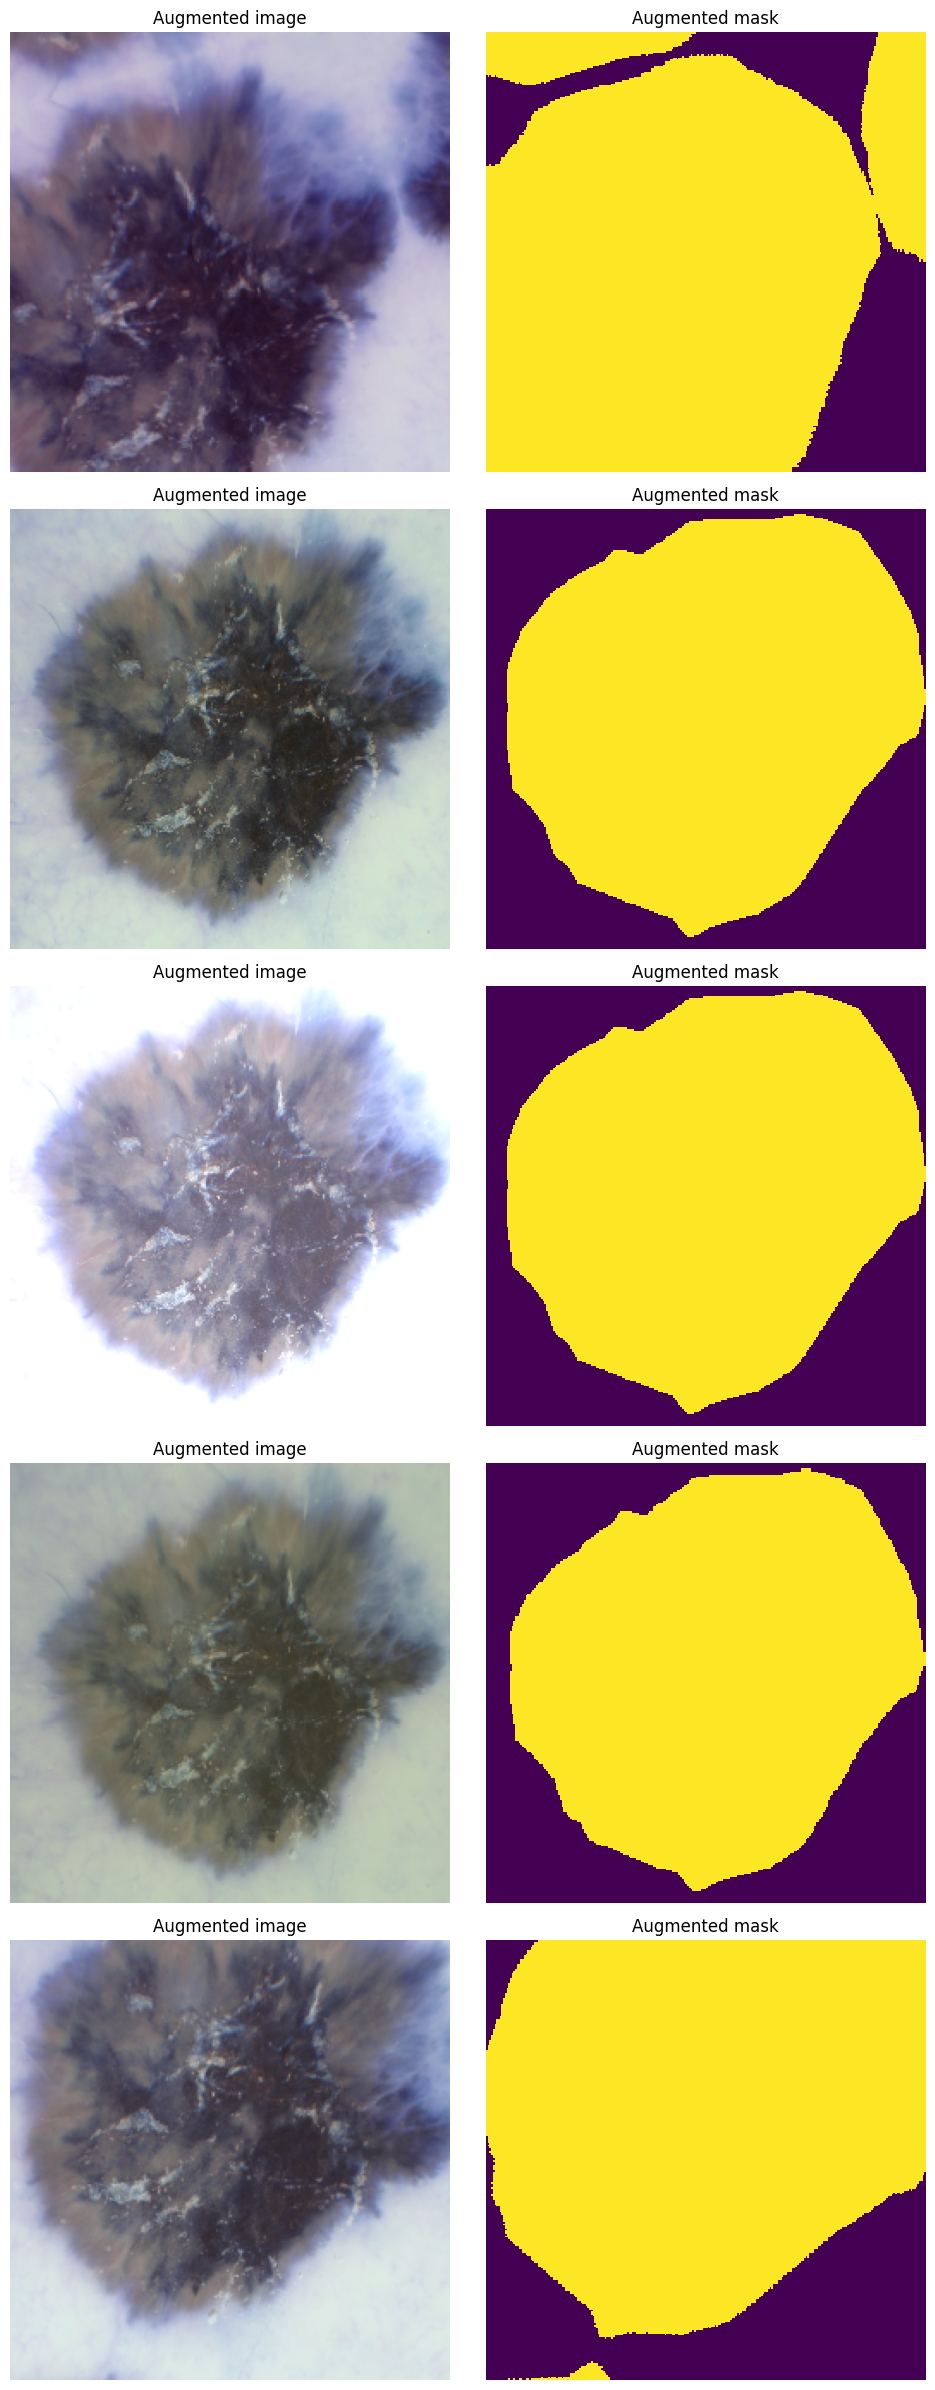

In [14]:
visualize_augmentations(train_data,idx=102)

In [31]:
# U-Net parts
class DownConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(DownConv,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
        self.act = nn.ReLU()
        
    def forward(self,x:torch.Tensor):
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        return x

class UpConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(UpConv,self).__init__()
        self.upConv = nn.ConvTranspose2d(in_channels,out_channels,kernel_size=2,stride=2)
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
        self.act = nn.ReLU()
        
    def forward(self,x:torch.Tensor,conc_x:torch.Tensor):
        x = self.upConv(x)
        if x.shape[2:] != conc_x.shape[2:]:
            conc_x = F.center_crop(conc_x, [x.shape[2], x.shape[3]])
        x = torch.cat([x, conc_x], dim=1)
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        return x
    
class MiddleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(MiddleConv,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
        self.act = nn.ReLU()
        
    def forward(self,x:torch.Tensor):
        x = self.conv1(x)
        x = self.act(x)        
        x = self.conv2(x)        
        x = self.act(x)
        return x
    
    
    
# Build the U-net architecture

class UNet(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(UNet,self).__init__()
        self.encoder = nn.ModuleList([DownConv(i,o) for i,o in [(in_channels,64),(64,128),(128,256),(256,512)]])
        self.decoder = nn.ModuleList([UpConv(i,o) for i,o in [(1024, 512), (512, 256), (256, 128), (128, 64)]])        
        self.middleConv = MiddleConv(512,1024)
        self.finalConv = nn.Conv2d(64,out_channels,kernel_size = 1)
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        pass_through = []
        for block in self.encoder:
            x = block(x)
            pass_through.append(x)
            x = self.pool(x)

        x = self.middleConv(x)
        
        for block in self.decoder:
            x = block(x, pass_through.pop())
                
        x = self.finalConv(x)
        
        return x

In [32]:
sample = next(iter(train_data))
sample[0].shape

torch.Size([3, 256, 256])

In [33]:
model = UNet(3,1)
pred = model(sample[0].unsqueeze(0))


Input shape: torch.Size([1, 3, 256, 256])
After encoder block: torch.Size([1, 64, 256, 256])
After pooling: torch.Size([1, 64, 128, 128])
After encoder block: torch.Size([1, 128, 128, 128])
After pooling: torch.Size([1, 128, 64, 64])
After encoder block: torch.Size([1, 256, 64, 64])
After pooling: torch.Size([1, 256, 32, 32])
After encoder block: torch.Size([1, 512, 32, 32])
After pooling: torch.Size([1, 512, 16, 16])
After middle block: torch.Size([1, 1024, 16, 16])
After decoder block: torch.Size([1, 512, 32, 32])
After decoder block: torch.Size([1, 256, 64, 64])
After decoder block: torch.Size([1, 128, 128, 128])
After decoder block: torch.Size([1, 64, 256, 256])
Final output shape: torch.Size([1, 1, 256, 256])


In [34]:
pred.shape

torch.Size([1, 1, 256, 256])

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    for image,mask in train_loader:
        output = model(image)
        loss = criterion(output,mask)
    